Exploratory analysis of the [Databricks Dolly training data](https://huggingface.co/datasets/databricks/databricks-dolly-15k).

In [0]:
%pip install sentence-transformers scipy

Python interpreter will be restarted.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=04b522cd9323aa8c21a14cfe5551d8173ae71b423bb3fabf84bc950e16b74ed5
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
  Created wheel for lit: filename=lit-16.0.6-py3-none-any.whl size=93602 sha256=46757e77e3162786d23ce705ccea9b6b779518c459d555525b637da8759284fa
  Stored in directory: /root/.cache/pip/wheels/a5/36/d6/cac2e6fb891889b33a548f2fddb8b4b7726399aaa2ed32b188
Succ

In [0]:
import pandas as pd
import numpy as np
import requests
import json
import time

DATA_URL = "https://datasets-server.huggingface.co/rows?dataset=databricks%2Fdatabricks-dolly-15k&config=databricks--databricks-dolly-15k"

lines_per_chunk = 100

chunks = []
chunk_number = 0

def get_chunk(url):
  resp = requests.get(url,  stream=True)
  chunk_result = next(resp.iter_lines())
  return json.loads(chunk_result.decode('utf-8'))


while True:
    chunk_offset = chunk_number * lines_per_chunk
    chunk_end = chunk_offset + lines_per_chunk
    progress_char = '+'
    sleep_time = 1
    while True:
      chunk_data = get_chunk(DATA_URL + f"&split=train&offset={chunk_offset}&limit={chunk_end}")
      print(progress_char, end='')
      if 'error' in chunk_data.keys():
        # {'error': "Authentication check on the Hugging Face Hub failed or timed out. Please try again later, it's a temporary internal issue."}
        progress_char = '-'
        time.sleep(sleep_time)
        sleep_time = sleep_time * 2
      else:
        break
      
    chunk_rows = [r['row'] for r in chunk_data['rows']]
    if len(chunk_rows) == 0:
        break
    chunks.append(pd.DataFrame(chunk_rows))
    chunk_number += 1

dolly_data = pd.concat(chunks).reset_index()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [0]:
dolly_data

,index,instruction,context,response,category
0,0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...,closed_qa
1,1,Which is a species of fish? Tope or Rope,,Tope,classification
2,2,Why can camels survive for long without water?,,Camels use the fat in their humps to keep them...,open_qa
3,3,"Alice's parents have three daughters: Amy, Jes...",,The name of the third daughter is Alice,open_qa
4,4,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981.",closed_qa
...,...,...,...,...,...
15006,6,How do i accept the change,,Embrace the change and see the difference,brainstorming
15007,7,What is a laser and who created it?,A laser is a device that emits light through a...,A laser is a device that emits light from an e...,summarization
15008,8,What is the difference between a road bike and...,,Road bikes are built to be ridden on asphalt a...,open_qa
15009,9,How does GIS help in the real estate investmen...,,"Real estate investors depend on precise, accur...",general_qa


In [0]:
dolly_data['has_context'] = [len(x) > 0 for x in dolly_data['context']]

pd.crosstab(dolly_data['category'], dolly_data['has_context'])

has_context,False,True
category,,
brainstorming,1766,0
classification,2136,0
closed_qa,0,1773
creative_writing,709,0
general_qa,2191,0
information_extraction,0,1506
open_qa,3742,0
summarization,0,1188


# Add embeddings

In [0]:
from sentence_transformers import SentenceTransformer
sentxformer = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2') # 'sentence-transformers/all-mpnet-base-v2'
# Note: the download progress bar widget may not display correctly on some platforms; this shouldn't hurt anything.

In [0]:
dolly_data['instruction_vector'] = sentxformer.encode(dolly_data['instruction'].values).tolist()
dolly_data['response_vector'] = sentxformer.encode(dolly_data['response'].values).tolist()

In [0]:
def add_cluster_cols(df, embedding_col='embedding', prefix='cluster', letters='ABCDE', max_threshold=1):
    from scipy.cluster.hierarchy import ward, fcluster
    from scipy.spatial.distance import pdist
    import math

    # cluster the sentence vectors at various levels
    X = df[embedding_col].tolist()
    y = pdist(X, metric='cosine')
    z = ward(y)

    for i in range(len(letters)):
        letter = letters[i]
        col_name = f'{prefix}_{letter}'
        cluster_id = fcluster(z, max_threshold/2**i, criterion='distance')
        digits = 1 + math.floor(math.log10(max(cluster_id)))
        df[col_name] = [col_name + str(cid).zfill(digits) for cid in cluster_id]

    cluster_cols = [c for c in df.columns if c.startswith(f'{prefix}_')]
    return df.sort_values(by=cluster_cols)

In [0]:
dolly_data = add_cluster_cols(dolly_data, embedding_col='instruction_vector', prefix='inst', letters='ABC', max_threshold=8)
dolly_data = add_cluster_cols(dolly_data, embedding_col='response_vector',    prefix='resp', letters='ABC', max_threshold=8)

dolly_data

,index,instruction,context,response,category,has_context,instruction_vector,response_vector,inst_A,inst_B,inst_C,resp_A,resp_B,resp_C
10398,98,What is the difference between a sitar and a t...,,Both the sitar and tanpura are string music in...,open_qa,False,"[0.23483841121196747, 0.035424597561359406, -0...","[0.029096610844135284, -0.08276065438985825, -...",inst_A05,inst_B18,inst_C074,resp_A01,resp_B01,resp_C001
6297,97,"What other names are used to refer to Taweret,...",,The Egyptian goddess Taweret can be called Tao...,brainstorming,False,"[0.02864036336541176, -0.04502595216035843, 0....","[0.017699213698506355, -0.033530496060848236, ...",inst_A06,inst_B20,inst_C086,resp_A01,resp_B01,resp_C001
7374,74,Identify which instrument is string or woodwin...,,"Tromboon is woodwind, Guitaro is string.",classification,False,"[-0.23241925239562988, -0.25338268280029297, 0...","[-0.40016844868659973, -0.5081475377082825, -0...",inst_A19,inst_B89,inst_C408,resp_A01,resp_B01,resp_C001
14499,99,Identify which instrument is string or woodwin...,,"Agiarut is string, Piccolo is woodwind.",classification,False,"[0.01590496301651001, 0.1605529487133026, -0.0...","[0.25810325145721436, 0.15485166013240814, -0....",inst_A19,inst_B89,inst_C408,resp_A01,resp_B01,resp_C001
19,19,Identify which instrument is string or percuss...,,"Gudok is string, Cantaro is percussion.",classification,False,"[-0.18485254049301147, -0.027913633733987808, ...","[-0.2516821026802063, -0.18359269201755524, -0...",inst_A19,inst_B89,inst_C409,resp_A01,resp_B01,resp_C001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11820,20,"Explain me the concept of ""Karma"" in Buddhism.",,Karma is one of the most misunderstood aspects...,brainstorming,False,"[-0.20534418523311615, 0.3266623914241791, -0....","[-0.16294480860233307, -0.09131135791540146, 0...",inst_A05,inst_B18,inst_C074,resp_A19,resp_B90,resp_C405
9961,61,The highest civilian honour of Ladakh dPalr Ng...,,Dalai Lama,open_qa,False,"[-0.08760681003332138, 1.1373100280761719, -0....","[0.0795951560139656, 0.3229422867298126, 0.004...",inst_A07,inst_B31,inst_C138,resp_A19,resp_B90,resp_C405
8202,2,List down some points about Dalai Lama from th...,Since the time of the 5th Dalai Lama in the 17...,1. Since the 5th Dalai Lama's reign in the 17t...,summarization,True,"[0.02106330543756485, 0.2816465198993683, 0.09...","[-0.11355424672365189, 0.3420252799987793, -0....",inst_A12,inst_B54,inst_C248,resp_A19,resp_B90,resp_C405
8833,33,"In the given text, List down some important po...",Pope Adrian V (Latin: Adrianus V; c. 1210/1220...,"1. Pope Adrian V, sometimes known as Adrianus ...",summarization,True,"[0.2765704393386841, 0.5620720386505127, -0.03...","[0.23952026665210724, 0.31203174591064453, 0.0...",inst_A12,inst_B54,inst_C248,resp_A19,resp_B90,resp_C405


In [0]:
spark.createDataFrame(dolly_data).write.mode('overwrite').saveAsTable('dolly_data')

In [0]:
%sql

select * from dolly_data limit 10

index instruction context response category has_context instruction_vector response_vector inst_A inst_B inst_C resp_A resp_B resp_C 98 What is the difference between a sitar and a tanpura? Both the sitar and tanpura are string music instruments. The sitar has frets and is used for composing and playing complete melodies. Sitar players are like guitar players who perform solo or as part of an ensemble band. The tanpura on the other hand does not have any frets and is only an accompanying instrument. Its strings provide a continued background rhythm to a music performance. While the tanpura alone cannot be used for composing a melody, a music performance is incomplete without a tanpura. open_qa false List(0.23483841121196747, 0.035424597561359406, -0.09311901777982712, 0.46601179242134094, -1.0795570611953735, -0.4007788300514221, -0.14855948090553284, 0.014663519337773323, 0.4006858766078949, 0.32551246881484985, 0.2922392189502716, -0.28319188952445984, 0.24097074568271637, -0.14265328645706177, 0.4804055392742157, 0.07857949286699295, 0.02671963907778263, 0.0529014989733696, 0.029486289247870445, 0.14100433886051178, 0.11342250555753708, 0.497024267911911, -0.4364233613014221, -0.21293708682060242, 0.03539174422621727, -0.2125539630651474, 0.281107634305954, 0.2954545021057129, 0.06080429628491402, 0.21922224760055542, -0.18099401891231537, -0.16940483450889587, -0.5502873659133911, 0.12136495858430862, -0.08107532560825348, 0.2830664813518524, -0.2611640393733978, 0.16020064055919647, -0.04741893708705902, 0.014107591472566128, 0.04769081622362137, 0.08273181319236755, 0.7260856628417969, 0.08141829073429108, -0.03631274029612541, 0.0857115089893341, -0.44897574186325073, -0.3388645052909851, -0.17250864207744598, 0.06760477274656296, -0.26118117570877075, -0.04803820326924324, -0.012117418460547924, 0.38708725571632385, -0.34167802333831787, -0.41435447335243225, -0.01592717133462429, 0.30140143632888794, 0.03283726051449776, -0.04736458882689476, 0.3192024230957031, 0.012454928830265999, -0.018451476469635963, 0.33395129442214966, 0.2676936388015747, -0.38717421889305115, -0.17801637947559357, -0.46319007873535156, 0.37471190094947815, 0.2517853379249573, -0.3632245361804962, -0.12543745338916779, 0.67055743932724, -0.5090171694755554, -0.32696208357810974, -0.9003141522407532, -0.6429081559181213, 0.13623328506946564, -0.18012456595897675, -0.1978030949831009, 0.269494891166687, 0.29192620515823364, -0.2350882589817047, 0.3779991865158081, -0.38009199500083923, 0.47435566782951355, 0.20078033208847046, -0.07217666506767273, -0.24512271583080292, -0.6467319130897522, 0.5971785187721252, 0.23292109370231628, -0.17051996290683746, -0.1718222051858902, -0.21596494317054749, -0.7581241726875305, -0.14775951206684113, 0.19060491025447845, -0.008243638090789318, 0.21839293837547302, -0.15109048783779144, 0.29154518246650696, -0.08988997340202332, 0.12206803262233734, -0.4117692708969116, -0.07671238481998444, -0.2583053410053253, -0.3563167154788971, -0.22002436220645905, 0.4450380206108093, 0.11245639622211456, 0.13080209493637085, -0.1703706830739975, -0.03898070752620697, -0.4522798955440521, 0.25061482191085815, -0.22515827417373657, -0.10082940012216568, 0.4181753098964691, -0.1458214372396469, -0.15099337697029114, -0.16863521933555603, 0.1345527470111847, 0.11247686296701431, 0.0872289165854454, -0.46397319436073303, -0.09768983721733093, 0.24137909710407257, -0.2721952199935913, 0.18496721982955933, -0.09025905281305313, -0.3529099225997925, 0.40502578020095825, -0.8463937044143677, -0.011414673179388046, 0.3178699314594269, 0.1517840474843979, 0.292378306388855, 0.07533330470323563, 0.04750783368945122, 0.0667073205113411, -0.05595197528600693, 0.458029180765152, 0.018616508692502975, 0.1750040352344513, -0.3495433032512665, -0.0755743756890297, -0.6739807724952698, -0.22006556391716003, 0.26785215735435486, 0.16354313492774963, 0.22242169082164764, 0.2384422868490219, -0.6510341763496399, 0.42482101917266846, -0.33815

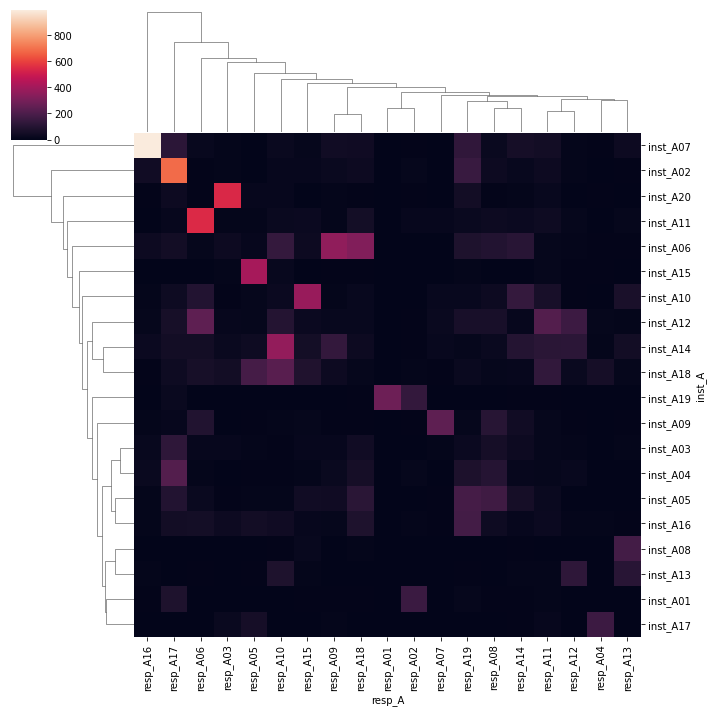

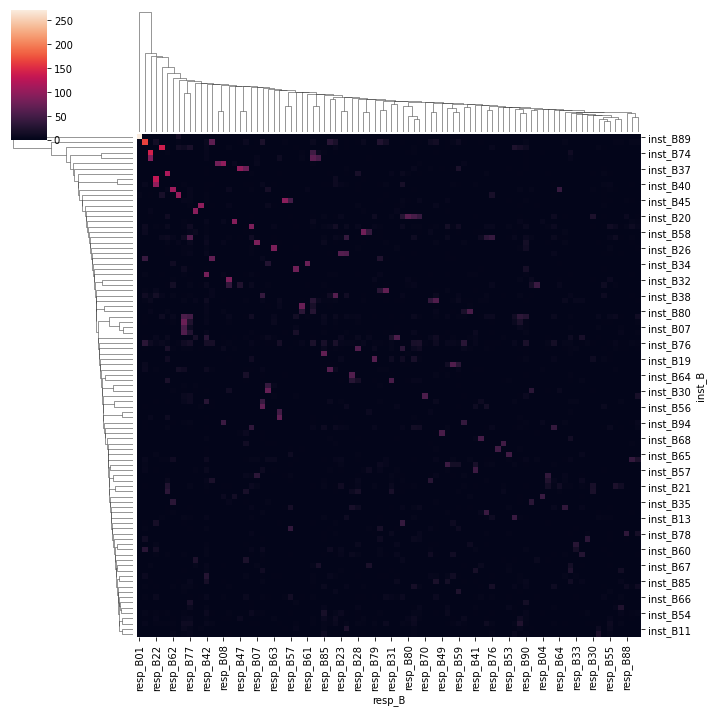

In [0]:
import seaborn as sns

for letter in 'AB':
    X = pd.crosstab(dolly_data[f'inst_{letter}'], dolly_data[f'resp_{letter}'])
    sns.clustermap(X)

## Visualize cluster relationships as a co-occurrence graph.

Graphs are often well suited to sparse data.

In [0]:
dd_wide = dolly_data[ ['category', 'inst_B', 'resp_B'] ] \
    .reset_index() \
    .rename(columns={'index':'basket', 'inst_B': 'instruction_cluster', 'resp_B': 'response_cluster'})

basket_item = pd.melt(dd_wide, 
                        id_vars='basket', 
                        value_vars=['category', 'instruction_cluster', 'response_cluster'],
                        var_name='type', value_name='thing'
                     ).sort_values(['basket', 'type'])

basket_item['item'] = basket_item['type'] + '::' + basket_item['thing']

basket_item = basket_item[ ['basket', 'item']]

basket_item

,basket,item
4610,0,category::closed_qa
19621,0,instruction_cluster::inst_B38
34632,0,response_cluster::resp_B25
8804,1,category::classification
23815,1,instruction_cluster::inst_B93
...,...,...
18211,15009,instruction_cluster::inst_B49
33222,15009,response_cluster::resp_B19
11371,15010,category::general_qa
26382,15010,instruction_cluster::inst_B56


In [0]:
def get_item_pair_stats(item_pair_df):
    # item_pair_df must have columns named 'basket', and 'item'.
    
    import sqlite3 # we're using this for portability; you can run this code on your favorite SQL database.

    db = sqlite3.connect(":memory:")
    
    item_pair_df.to_sql("basket_item", db, if_exists="replace")


    ITEM_PAIR_STATS_QUERY = """with 
      bi as (
        select basket, item
          from basket_item
          group by basket, item  -- be sure we only count one of each kind of item per basket
      ),
      item_counts as (
        select item, count(*) item_count -- same as the number of baskets containing this item (see above)
          from bi
          group by item
      ),
      bi_count as (
        select bi.*, ic.item_count  -- basket, item, item_count
          from bi
            join item_counts ic on bi.item=ic.item
      ),
      ips as (
          select bi1.item item1, bi2.item item2,
                  bi1.item_count item1_count, bi2.item_count item2_count,
                  count(*) as both_count              
              from bi_count bi1
                join bi_count bi2  -- joining the table to itself
                  on bi1.basket = bi2.basket  -- two items in the same basket
                  and bi1.item != bi2.item    -- don't count the item being in the basket with itself
              group by bi1.item, bi1.item_count, 
                       bi2.item, bi2.item_count
      ),
      cc as (
        SELECT item1, item2, item1_count, item2_count, both_count,
              CAST(item1_count AS FLOAT)/(select count(distinct basket) from basket_item) as item1_prevalence, -- fraction of all baskets with item1
              CAST(item2_count AS FLOAT)/(select count(distinct basket) from basket_item) as item2_prevalence, -- fraction of all baskets with item2
              CAST(both_count AS FLOAT)/CAST(item1_count AS FLOAT) AS confidence  -- fraction of baskets with item1 that also have item2
          FROM ips
      )
    select *, confidence/item2_prevalence lift from cc
    """

    return pd.read_sql_query(ITEM_PAIR_STATS_QUERY, db)


def get_nodes_and_edges_from_item_pair_stats(cooccurrence_pdf):
    """
    Convert a Pandas dataframe of item-pair statistics to separate dataframes for nodes and edges.
    """
    from collections import Counter
    
    item_stats = {r['item1']:{'count':r['item1_count'], 'prevalence':r['item1_prevalence']} 
                    for idx, r in cooccurrence_pdf.iterrows()}
 
    item_stats.update({r['item2']:{'count':r['item2_count'], 'prevalence':r['item2_prevalence']} 
                    for idx, r in cooccurrence_pdf.iterrows()})
 
    nodes_df = pd.DataFrame([{'label':k,'count':v['count'], 'prevalence':v['prevalence']}  
                    for k,v in item_stats.items()])
    nodes_df['id'] = nodes_df.index
   
    edges_df = cooccurrence_pdf.copy()
    node_id = {r['label']:r['id'] for idx, r in nodes_df.iterrows()}
    edges_df['from'] = [node_id[nn] for nn in edges_df['item1']]
    edges_df['to'] = [node_id[nn] for nn in edges_df['item2']]
    
    print("Your graph will have {0} nodes and {1} edges.".format( len(nodes_df), len(edges_df) ))
 
    return nodes_df, edges_df[[ 'from', 'to', 'both_count', 'confidence', 'lift']]


def get_vis_js_html(nodes_df, edges_df):
    """
    Generate HTML encoding vis_js graph from Pandas dataframes of nodes and edges.
    """
    nodes_str = nodes_df.to_json(orient='records')
    edges_str = edges_df.to_json(orient='records')
    
    max_weight = max(edges_df['weight'])

    html_string = ( 
    f'    <script type="text/javascript">NODE_LIST={nodes_str};FULL_EDGE_LIST={edges_str};</script>\n'
    '\n'
        '\n'
    '        <script type="text/javascript" src="https://unpkg.com/vis-network/standalone/umd/vis-network.min.js"></script>\n'
    '        <script type="text/javascript">\n'
    '            function hello(){console.info("hello")}\n'
    '\n'
    '            const sign_color = {pos:"blue", neg:"red", zero:"black"}\n'
    '            const options = {physics:{maxVelocity: 1, minVelocity: 0.01}}\n'
    '            var edgeFilterSlider\n'
    '            var mynetwork\n'
    '            var motion_flag = false\n'
    '            function toggle_motion(){\n'
    '                motion_flag = !motion_flag\n'
    '                mynetwork.setOptions( { physics: motion_flag } )\n'
    '            }\n'
    '\n'
    '            function edgesFilter(edge){\n'
    '                return edge.value >= edgeFilterSlider.value\n'
    '            }\n'
    '\n'
    '            function init_network(){\n'
    '                document.getElementById("min_edge_weight_display").value = 0.5\n'
    '                document.getElementById("min_edge_weight").onchange = function(){\n'
    '                    document.getElementById("min_edge_weight_display").value = this.value\n'
    '                }\n'
    '\n'
    '                edgeFilterSlider = document.getElementById("min_edge_weight")\n'
    '                edgeFilterSlider.addEventListener("change", (e) => {edgesView.refresh()})\n'
    '                var container = document.getElementById("mynetwork")\n'
    '                var EDGE_LIST = []\n'
    '                for (var i = 0; i < FULL_EDGE_LIST.length; i++) {\n'
    '                    var edge = FULL_EDGE_LIST[i]\n'
    '                    edge["value"] = Math.abs(edge["weight"])\n'
    '                    edge["title"] = "weight " + edge["weight"]\n'
    '                    edge["sign"] = (edge["weight"] < 0) ? "neg" : "pos";\n'
    '                    edge["color"] = {color: sign_color[edge["sign"]] };\n'
    '                    edge["arrows"] = "to"\n'
    '                    EDGE_LIST.push(edge)\n'
    '                }\n'
    '\n'
    '                var nodes = new vis.DataSet(NODE_LIST)\n'
    '                var edges = new vis.DataSet(EDGE_LIST)\n'
    '                var nodesView = new vis.DataView(nodes)\n'
    '                var edgesView = new vis.DataView(edges, { filter: edgesFilter })\n'
    '                var data = { nodes: nodesView, edges: edgesView }\n'
    '                mynetwork = new vis.Network(container, data, options)\n'
    '\n'
    '            }\n'
    '            init_network()\n'
    '        </script>\n'
    '        <style type="text/css">#mynetwork {width: 100%; height: 500px; border: 3px}</style>\n'
    '        <button onclick=toggle_motion()>Toggle motion</button>\n'
    '        <div class="slidercontainer">\n'
    '            <label>minimum edge weight:\n'
    f'                <input type="range" min="0" max="{max_weight}" value="{max_weight/2}" step="{max_weight/100}" class="slider" id="min_edge_weight">\n'
    '                <input type="text" id="min_edge_weight_display" size="2">\n'
    '            </label>\n'
    '        </div>\n'
    '        <div id="mynetwork"></div>\n'

    )
    return html_string
        
    
def export_to_vis_js(nodes_df, edges_df, title, html_file_name):
    """
    Generate vis_js graph from Pandas dataframes of nodes and edges, and write to HTML file.
    """
    
    vis_js_html = get_vis_js_html(nodes_df, edges_df)
    page_html =  ('<!DOCTYPE html>\n'
        '<html lang="en">\n'
        '    <head>\n'
        f'       <title>{title}</title>\n'
        '    </head>\n'
        '    <body onload=init_network()>\n'
        f'{vis_js_html}'
        '\n'
        '    </body>\n'
        '</html>\n')
    
    with open(html_file_name, "wt") as html_file: 
        html_file.write(page_html)

In [0]:
item_pair_stats = get_item_pair_stats(basket_item)

item_pair_stats.sort_values('confidence', ascending=False)[0:15]

,item1,item2,item1_count,item2_count,both_count,item1_prevalence,item2_prevalence,confidence,lift
1706,instruction_cluster::inst_B09,category::information_extraction,141,1506,141,0.009393,0.100326,1.000000,9.967463
1471,instruction_cluster::inst_B02,category::open_qa,50,3742,49,0.003331,0.249284,0.980000,3.931261
4921,response_cluster::resp_B01,instruction_cluster::inst_B89,279,292,272,0.018586,0.019452,0.974910,50.117739
4913,response_cluster::resp_B01,category::classification,279,2136,270,0.018586,0.142296,0.967742,6.800924
5033,response_cluster::resp_B06,instruction_cluster::inst_B95,81,208,78,0.005396,0.013857,0.962963,69.495370
5028,response_cluster::resp_B06,category::classification,81,2136,78,0.005396,0.142296,0.962963,6.767339
4727,instruction_cluster::inst_B89,category::classification,292,2136,277,0.019452,0.142296,0.948630,6.666614
4732,instruction_cluster::inst_B89,response_cluster::resp_B01,292,279,272,0.019452,0.018586,0.931507,50.117739
7475,response_cluster::resp_B70,instruction_cluster::inst_B06,60,111,55,0.003997,0.007395,0.916667,123.964715
3009,instruction_cluster::inst_B41,category::classification,113,2136,103,0.007528,0.142296,0.911504,6.405708


In [0]:
nodes, edges = get_nodes_and_edges_from_item_pair_stats( item_pair_stats[ item_pair_stats['both_count'] > 175 ] )  # 50

Your graph will have 7 nodes and 12 edges.


In [0]:
nodes

,label,count,prevalence,id
0,category::classification,2136,0.142296,0
1,category::open_qa,3742,0.249284,1
2,instruction_cluster::inst_B49,486,0.032376,2
3,instruction_cluster::inst_B89,292,0.019452,3
4,response_cluster::resp_B01,279,0.018586,4
5,response_cluster::resp_B19,416,0.027713,5
6,response_cluster::resp_B22,361,0.024049,6


The [vis.js library](https://visjs.github.io/vis-network/docs/network/) understands a variety of keywords for node and edge attributes, like 'label', 'shape', 'color', etc. We can modify the nodes table to add some of these features.

In [0]:
type_color = {'category': '#FF9999', 'instruction_cluster': '#99FFFF', 'response_cluster': '#FFFF99'}

category_shape = {'brainstorming': 'box', 'classification': 'box', 'creative_writing': 'box', 
                  'general_qa': 'box', 'open_qa': 'box',
                  'closed_qa': 'star', 'information_extraction': 'star', 'summarization': 'star'}

nodes['type'] = [ x.split('::')[0] for x in nodes['label'] ]
nodes['color'] = [ type_color[my_type] for my_type in nodes['type'] ]

# use different shapes for categories that use context and those that do not

def get_shape(my_label):
    [my_type, my_detail] = my_label.split('::')
    if my_type == 'category':
        return category_shape[my_detail]
    else:
        return 'ellipse'
    
nodes['shape'] = [ get_shape(my_label) for my_label in nodes['label'] ]

def make_node_title(row, sentence_df):
    title = f"{row['label']}\n({row['type']}, {row['count']} examples)"
#     if row['category'] == 'adjective':
#         adjective = row['label']
#         examples = sentence_df[ sentence_df['bias_adjective'] == adjective ]['stereotype'].values
#         top_examples = [ f"{x[0]} ({x[1]} times)" for x in Counter(examples).most_common(5) ]
#         title += '\n' + '\n'.join(top_examples)
        
    return title

nodes['title'] = [ make_node_title(row, dolly_data) for row in nodes.to_dict(orient='records') ]

# 'label' is a reserved word that controls the text displayed on the node; let's simplify that
nodes['label'] = [ x.split('::')[1] for x in nodes['label'] ]

nodes

,label,count,prevalence,id,type,color,shape,title
0,classification,2136,0.142296,0,category,#FF9999,box,"category::classification\n(category, 2136 exam..."
1,open_qa,3742,0.249284,1,category,#FF9999,box,"category::open_qa\n(category, 3742 examples)"
2,inst_B49,486,0.032376,2,instruction_cluster,#99FFFF,ellipse,instruction_cluster::inst_B49\n(instruction_cl...
3,inst_B89,292,0.019452,3,instruction_cluster,#99FFFF,ellipse,instruction_cluster::inst_B89\n(instruction_cl...
4,resp_B01,279,0.018586,4,response_cluster,#FFFF99,ellipse,"response_cluster::resp_B01\n(response_cluster,..."
5,resp_B19,416,0.027713,5,response_cluster,#FFFF99,ellipse,"response_cluster::resp_B19\n(response_cluster,..."
6,resp_B22,361,0.024049,6,response_cluster,#FFFF99,ellipse,"response_cluster::resp_B22\n(response_cluster,..."


In [0]:
# Select the statistic to use for edge weight
edges['weight'] = edges['confidence']

In [0]:
# Filter out some of the weaker edges; we don't want to try to work with much more than a couple hundred edges.
len(edges[edges['confidence'] > 0.25])

Out[60]: 7

In [0]:
vis_js_html = get_vis_js_html(nodes, edges[edges['confidence'] > 0.25])

# from IPython.display import HTML
# HTML(vis_js_html)

displayHTML(vis_js_html)

Toggle motion 
 
 minimum edge weight:

In [0]:
# export_to_vis_js(nodes, edges[edges['confidence'] > 0.25], 
#                  title="Instruction-responce cluster pairings and types", html_file_name='dolly_instruction_response_graph.html')

StatementMeta(, , , Cancelled, )